<a href="https://colab.research.google.com/github/chihyanghsu0805/machine_learning/blob/tutorials/keras/bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook reimplements the tutorial on https://keras.io/examples/vision/bit/.

The orginal paper is https://arxiv.org/abs/1912.11370.

It introduced a simple recipe to Transfer Learning with  main components.

*   Pre-training
    1.   Scale
    2.   Group Normalization
    3.   Weight Standardization

*   Finetuning

    1.   BiT-HyperRule
    2.   Preprocessing

# Image Classification using BigTransfer (BiT)

## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

## Get Dataset

In [2]:
train_ds, validation_ds = tfds.load(
    "tf_flowers", split=["train[:80%]", "train[80%:]"], as_supervised=True,
)
# as_supervised return tuple(input, label)

## Exploratory Data Analysis

Text(0.5, 1.0, 'Training Labels: 2936 samples')

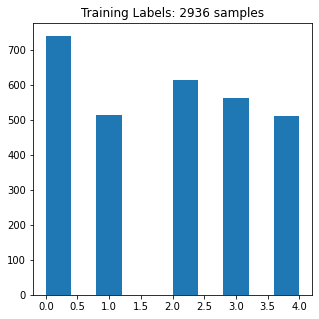

In [3]:
plt.figure(figsize=(5, 5))
labels = [y.numpy() for x, y in train_ds]
_ = plt.hist(labels)
plt.title(f"Training Labels: {len(labels)} samples")

Text(0.5, 1.0, 'DeV Labels: 734 samples')

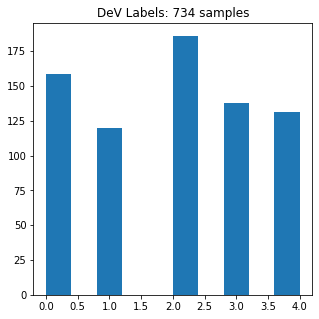

In [4]:
plt.figure(figsize=(5, 5))
labels = [y.numpy() for x, y in validation_ds]
_ = plt.hist(labels)
plt.title(f"DeV Labels: {len(labels)} samples")

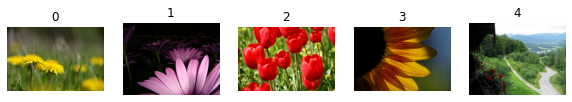

In [5]:
plt.figure(figsize=(10, 10))

for i in np.unique(labels):
    
    for x, y in train_ds.filter(lambda x,y: y == i).take(1):
    
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(x)
        plt.title(int(i))
        plt.axis("off")


## Define hyperparameters

In [6]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5  # number of classes

## Preprocessing for Transfer

During fine-tuning, we use the following standard data pre-processing: we
resize the image to a square, crop out a smaller random square, and randomly
horizontally flip the image at training time.

In [7]:
@tf.function
def preprocess_train(image, label):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0

    return (image, label)

At test time, we only resize the
image to a fixed size.

In [8]:
@tf.function
def preprocess_test(image, label):

    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0

    return (image, label)

We fine-tune BiT for 500 steps on small tasks, for 10k steps on medium tasks, and for 20k steps on large tasks. 

In [9]:
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)

During fine-tuning, we decay the learning rate by a factor of 10 at 30%, 60% and 90% of the training steps.

In [10]:
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

In [11]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

## Define the data pipeline

In [12]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps # Make sure enough data
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Visualize the processed training samples

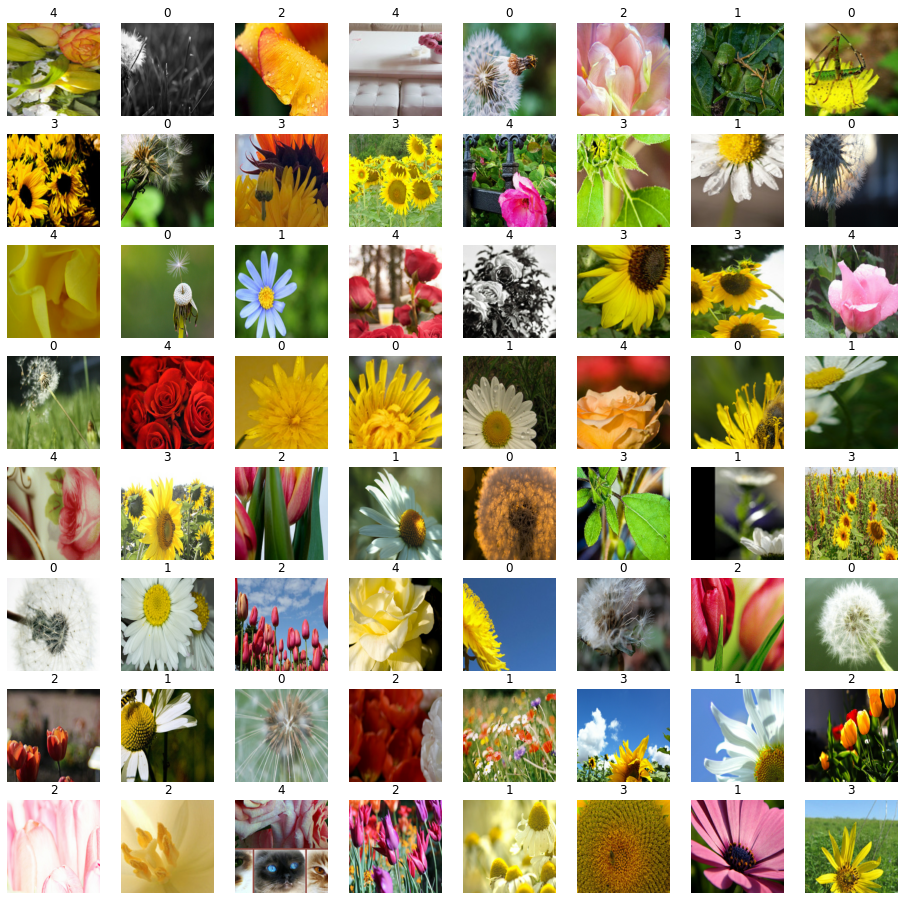

In [13]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(16, 16))
for n in range(BATCH_SIZE):
    ax = plt.subplot(8, 8, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

## Load pretrained TF-Hub model into a `KerasLayer`

In [14]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [15]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)

In [16]:
model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [17]:
learning_rate = 0.003 * BATCH_SIZE / 512

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
#   During fine-tuning, we decay the learning rate by a factor of
#   10 at 30%, 60% and 90% of the training steps.

optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [18]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [19]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

## Train the model

In [20]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/400
10/10 [==============================] - 39s 3s/step - loss: 0.8060 - accuracy: 0.7312 - val_loss: 0.2106 - val_accuracy: 0.9591
Epoch 2/400
10/10 [==============================] - 17s 2s/step - loss: 0.1878 - accuracy: 0.9359 - val_loss: 0.1160 - val_accuracy: 0.9605
Epoch 3/400
10/10 [==============================] - 17s 2s/step - loss: 0.1462 - accuracy: 0.9391 - val_loss: 0.1009 - val_accuracy: 0.9714
Epoch 4/400
10/10 [==============================] - 17s 2s/step - loss: 0.1250 - accuracy: 0.9641 - val_loss: 0.0881 - val_accuracy: 0.9700
Epoch 5/400
10/10 [==============================] - 18s 2s/step - loss: 0.1231 - accuracy: 0.9547 - val_loss: 0.1046 - val_accuracy: 0.9605


## Plot the training and validation metrics

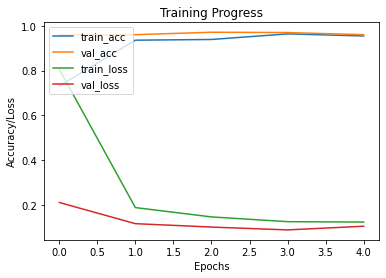

In [21]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()

plot_hist(history)

## Evaluate the model

In [22]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

12/12 [==============================] - 13s 1s/step - loss: 0.1009 - accuracy: 0.9714
Accuracy: 97.14%
